In [1]:
import os
os.chdir('..')
os.chdir('..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela/licencjat/eeg-site-effects


In [2]:
import pandas as pd
import numpy as np
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

RESULTS_PATH_SITE = 'results/tables/04_pca_sensitivity/pca_sensitivity_results_site.csv'
RESULTS_PATH_PATHO = 'results/tables/04_pca_sensitivity/pca_sensitivity_results_patho.csv'

RESULTS_FULL_PATH_SITE = 'results/tables/04_pca_sensitivity/pca_sensitivity_results_site_full.csv'
RESULTS_FULL_PATH_PATHO = 'results/tables/04_pca_sensitivity/pca_sensitivity_results_patho_full.csv'

METHODS = ['raw', 'sitewise', 'combat', 'neurocombat', 'covbat']

PCA_VARIANTS = [0.0, 1.0, 0.99, 0.95, 0.90, 0.80]

In [3]:
site_results_df = pd.read_csv(RESULTS_PATH_SITE)
patho_results_df = pd.read_csv(RESULTS_PATH_PATHO)

site_results_full_df = pd.read_csv(RESULTS_FULL_PATH_SITE)
patho_results_full_df = pd.read_csv(RESULTS_FULL_PATH_PATHO)

In [4]:
site_results_df['pca_var'] = site_results_df['pca_var'].fillna(0.0)
site_results_full_df['pca_var'] = site_results_full_df['pca_var'].fillna(1.0)

In [5]:
site_results_df = pd.concat([site_results_df, site_results_full_df], axis=0)
site_mean_results_df = site_results_df.groupby(['method', 'pca_var'], dropna=False).mean().drop(['fold_id', 'n_features'], axis=1)

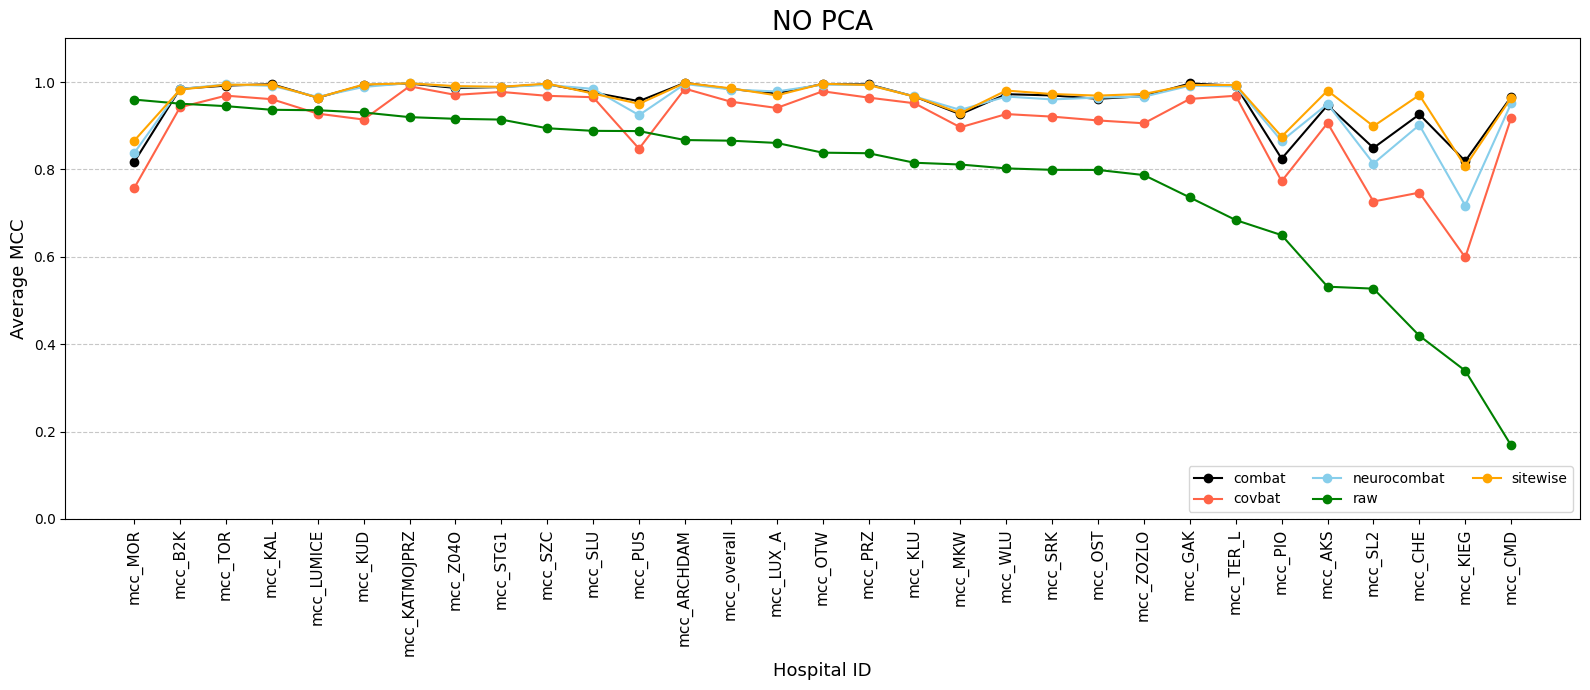

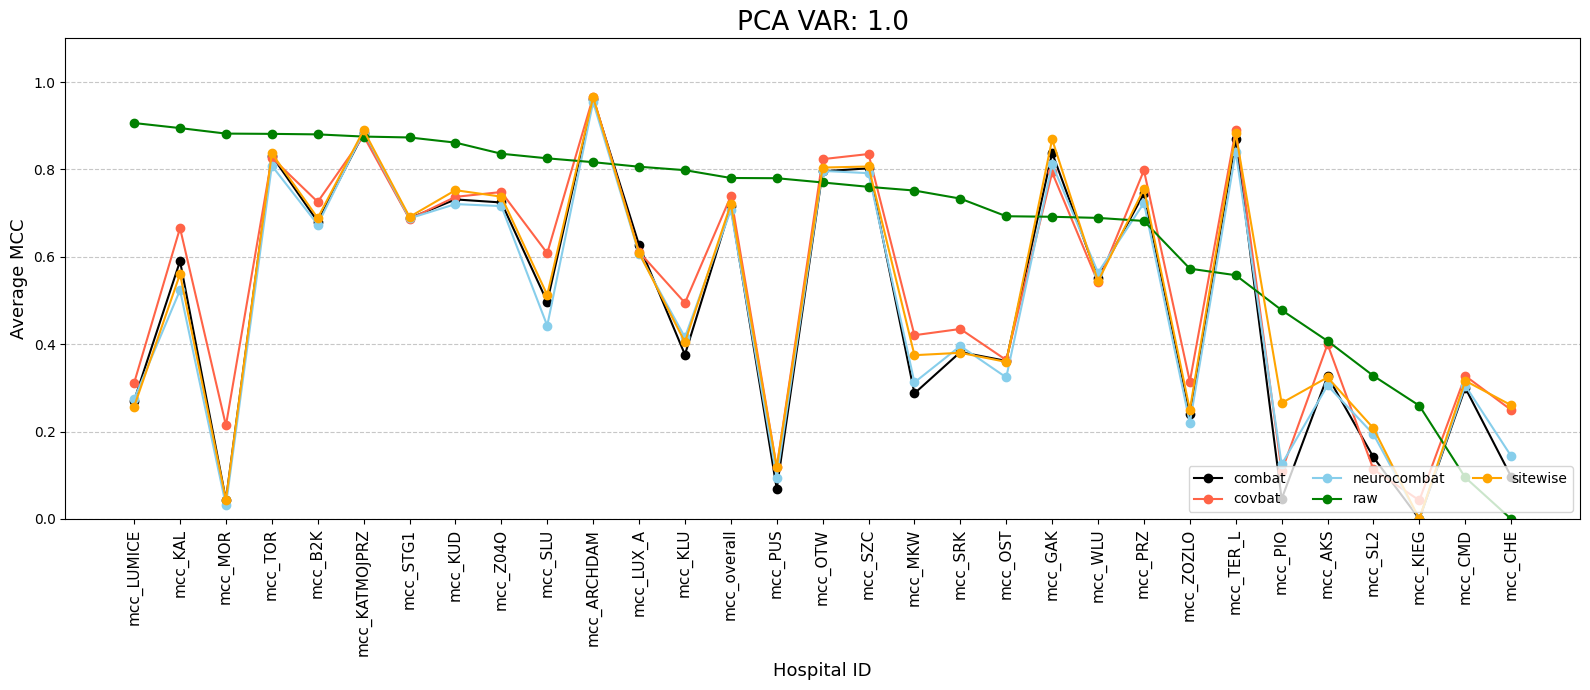

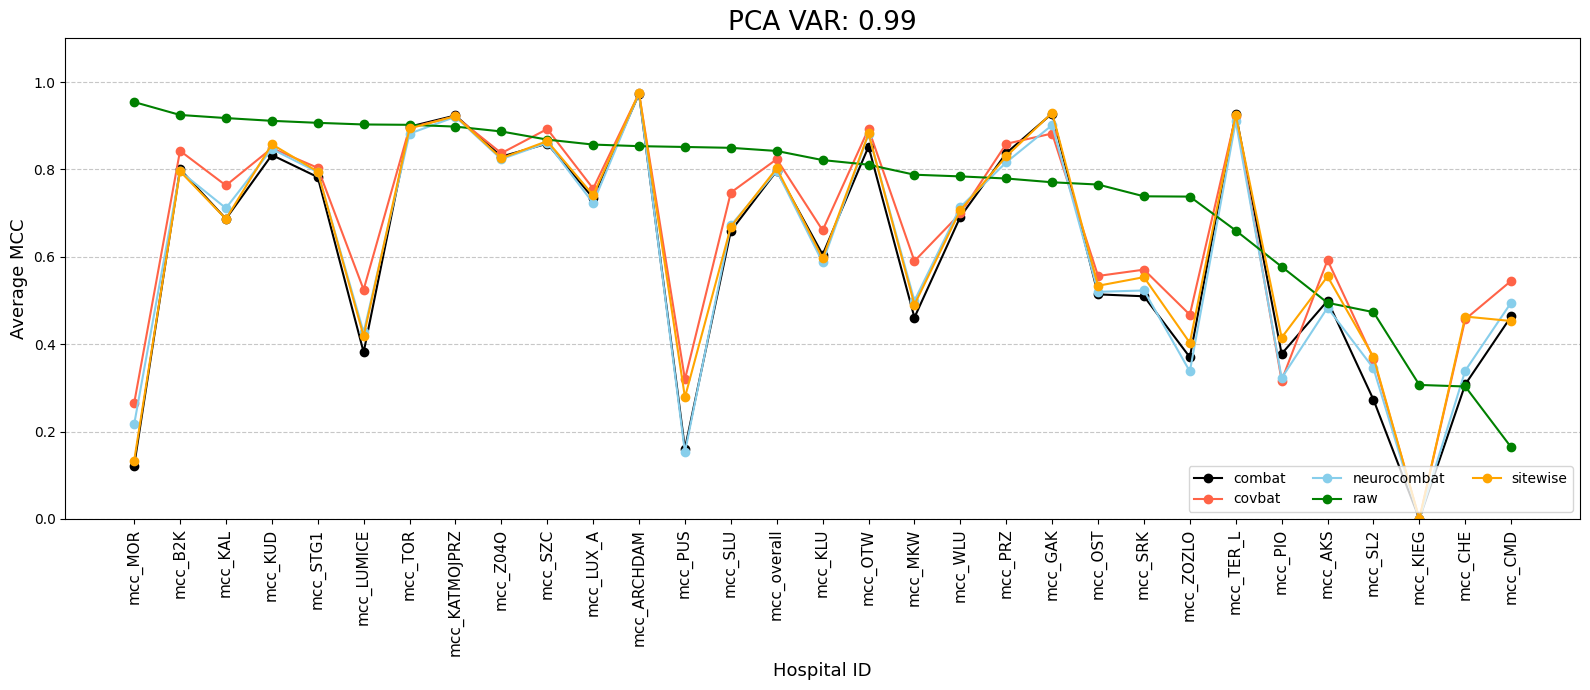

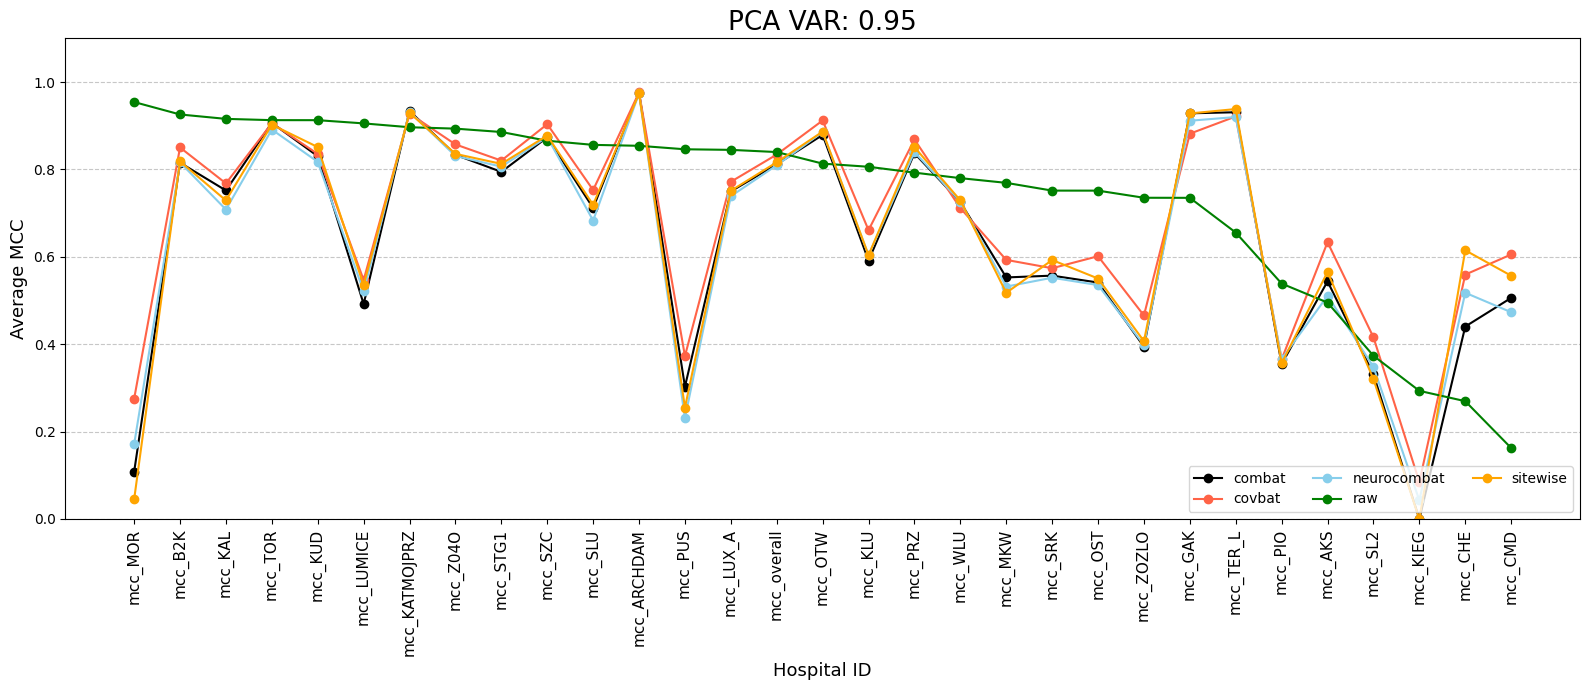

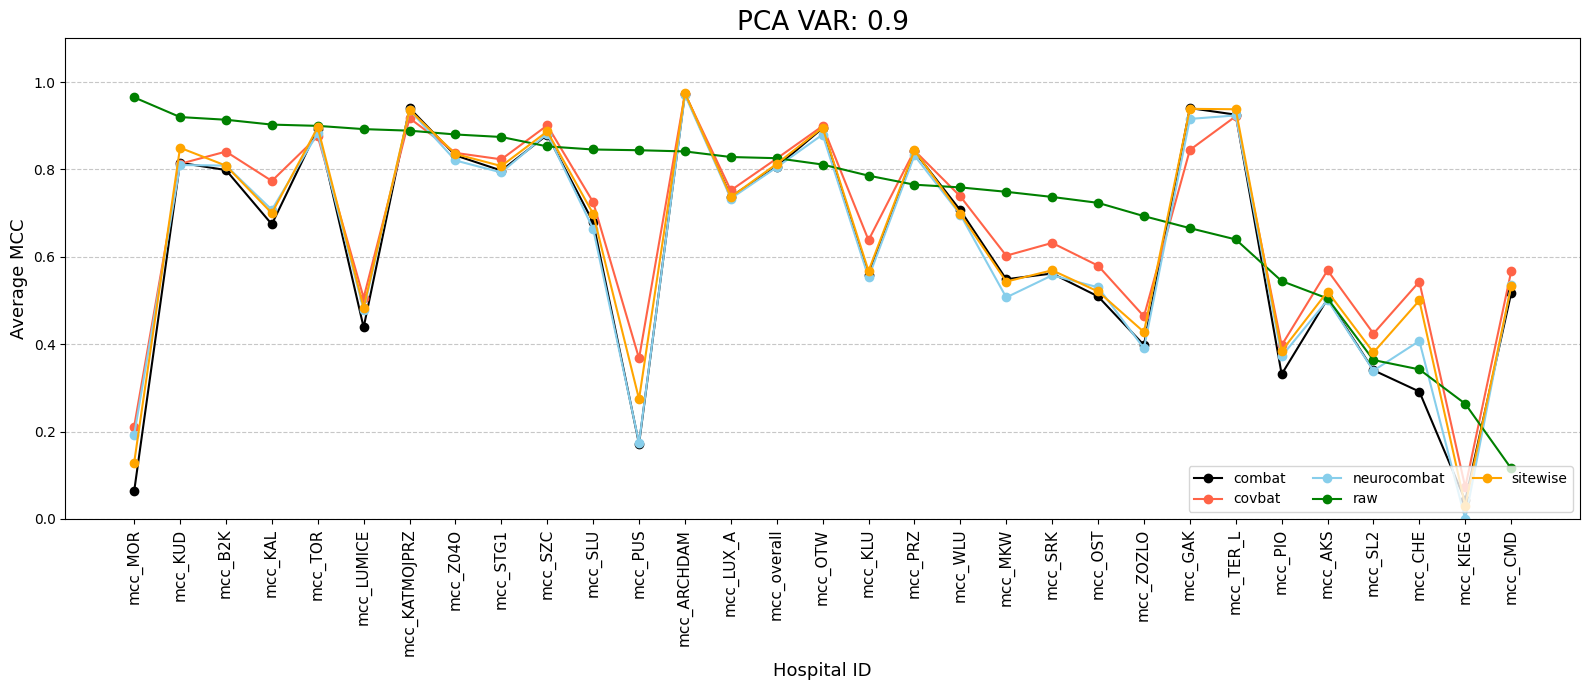

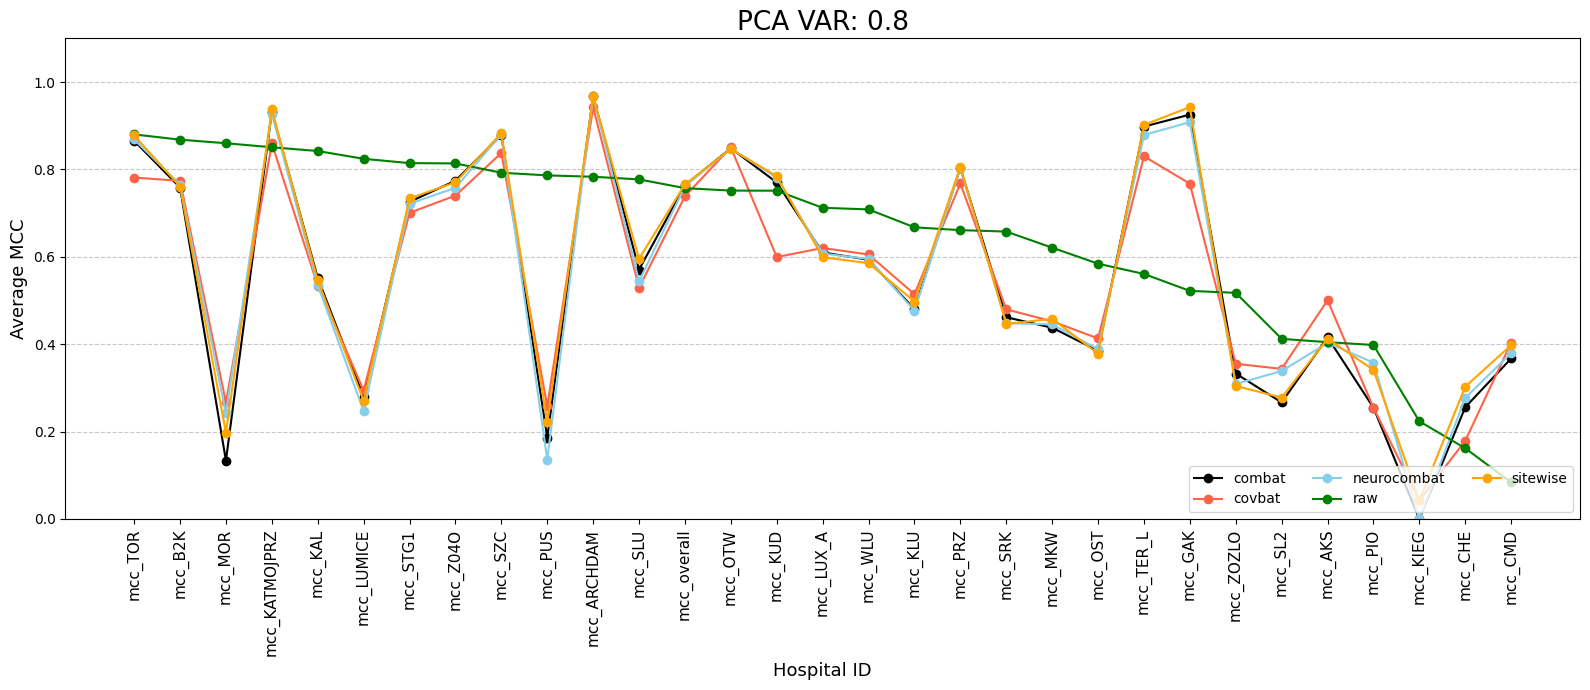

In [6]:
color_grid = [
    'black', 'tomato', 'skyblue', 'green',
    'orange', 'purple', 'brown', 'cyan',
    'magenta', 'yellow', 'pink', 'lime'
]

for pca_var in PCA_VARIANTS:
    plt.figure(figsize=(16, 7))
    reference_series = site_mean_results_df.loc['raw', pca_var]
    sort_idx = reference_series.values.argsort()[::-1]
    class_labels_sorted = reference_series.index.values[sort_idx]

    for method_idx, method in enumerate(site_mean_results_df.index.get_level_values(0).unique()):
        results_series = site_mean_results_df.loc[method, pca_var]
        mcc_values = [results_series.get(h, np.nan) for h in class_labels_sorted]

        plt.plot(
            class_labels_sorted,
            mcc_values,
            marker='o',
            linestyle='-',
            color=color_grid[method_idx],
            label=f"{method}"
        )

    plt.ylabel("Average MCC", fontsize=13)
    plt.xlabel("Hospital ID", fontsize=13)
    plt.xticks(rotation=90, fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1.1)
    plt.legend(loc='lower right', fontsize=10, ncol=3)
    plt.title("PCA VAR: " + str(pca_var) if pca_var != 0.0 else "NO PCA", fontsize=19)
    plt.tight_layout()
    plt.show()

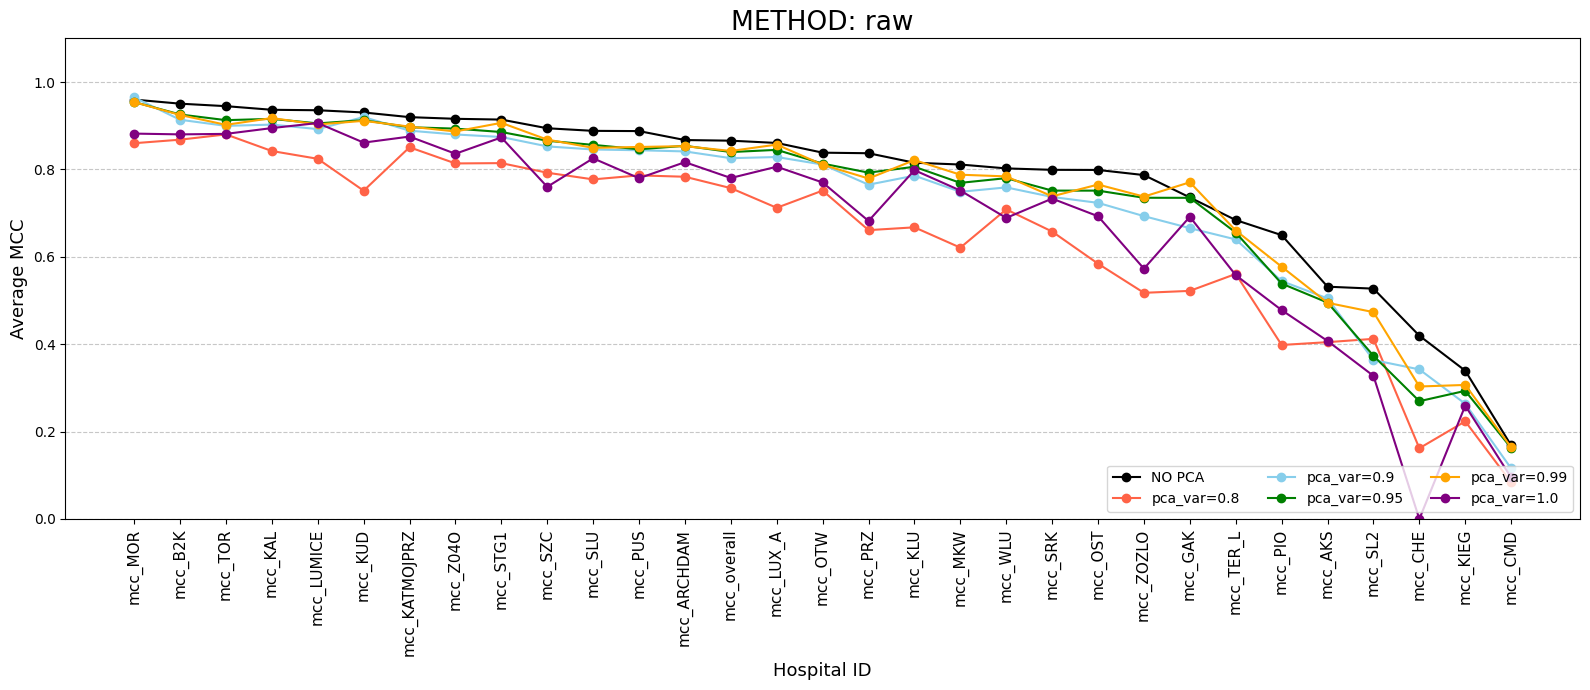

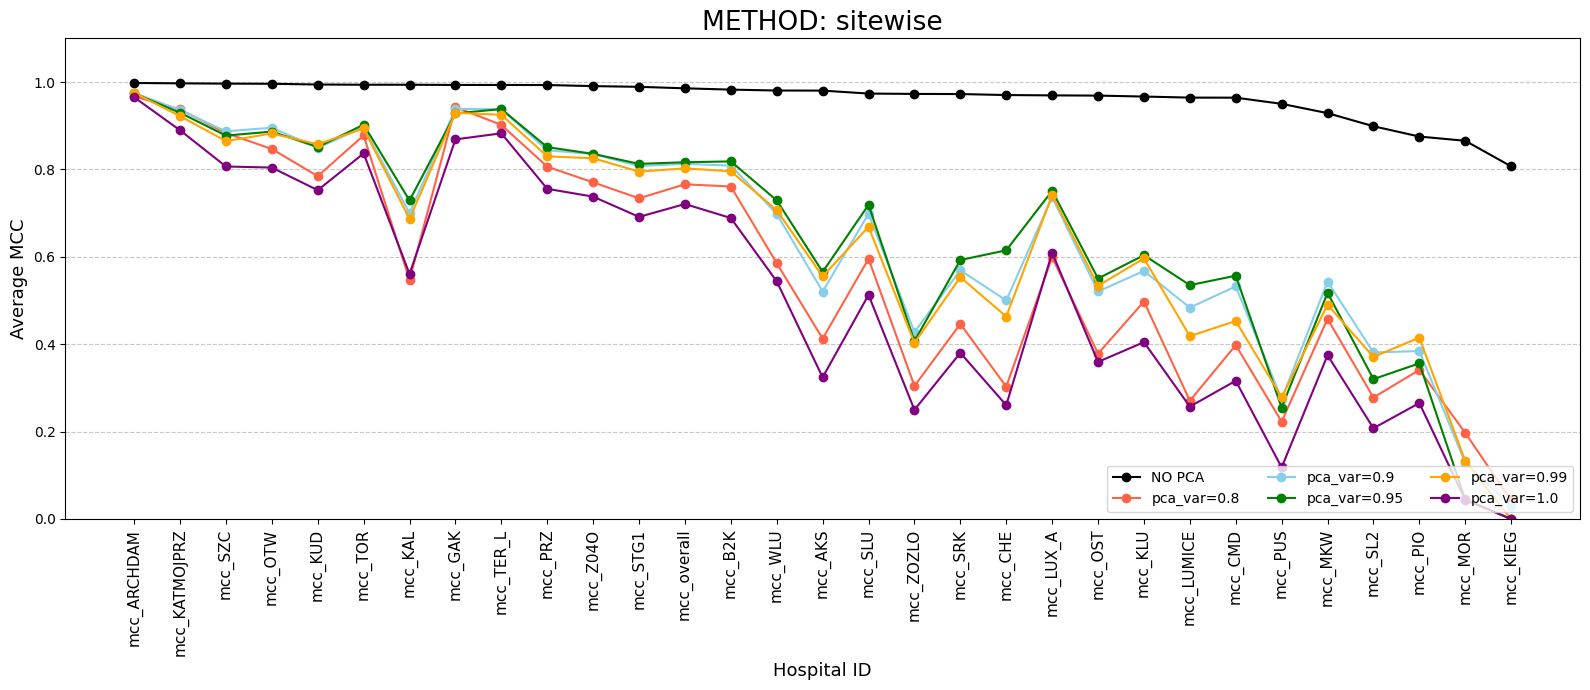

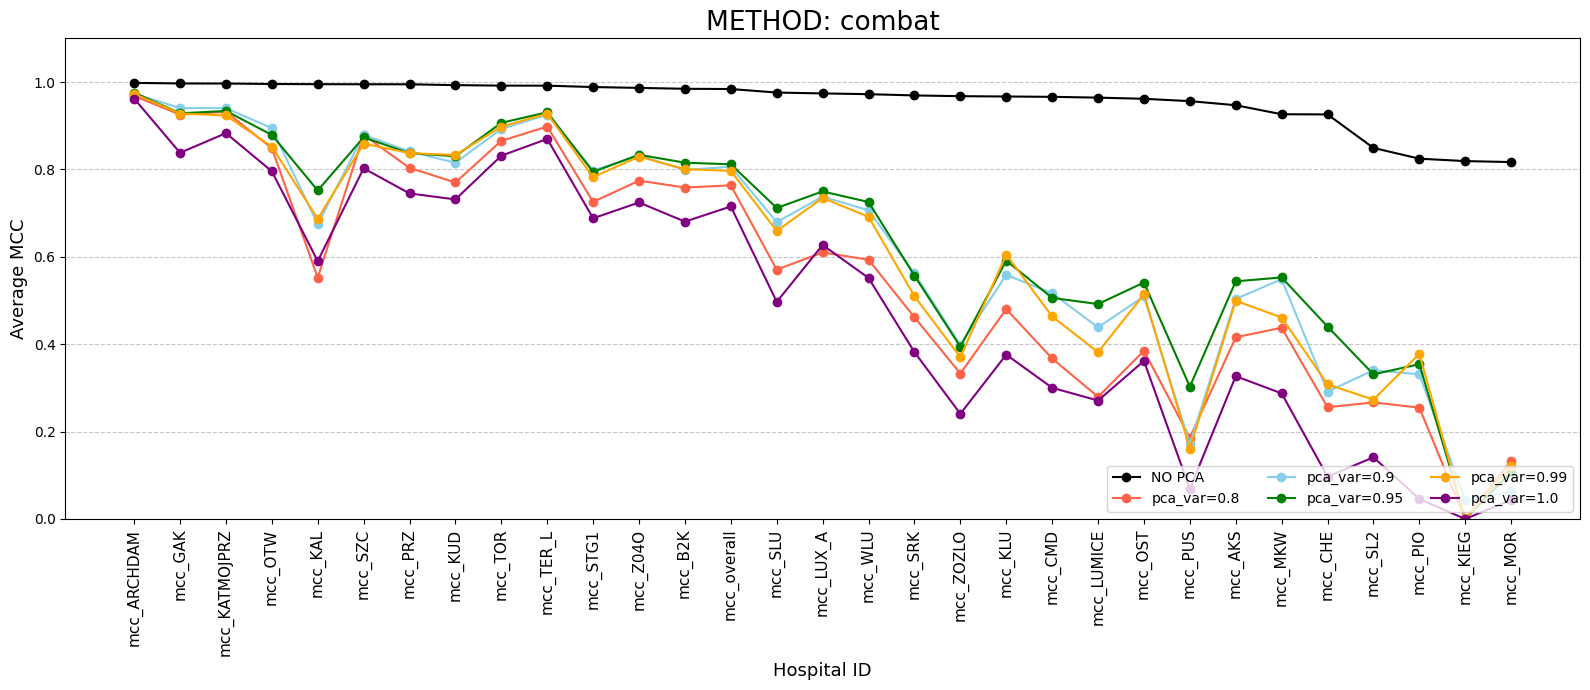

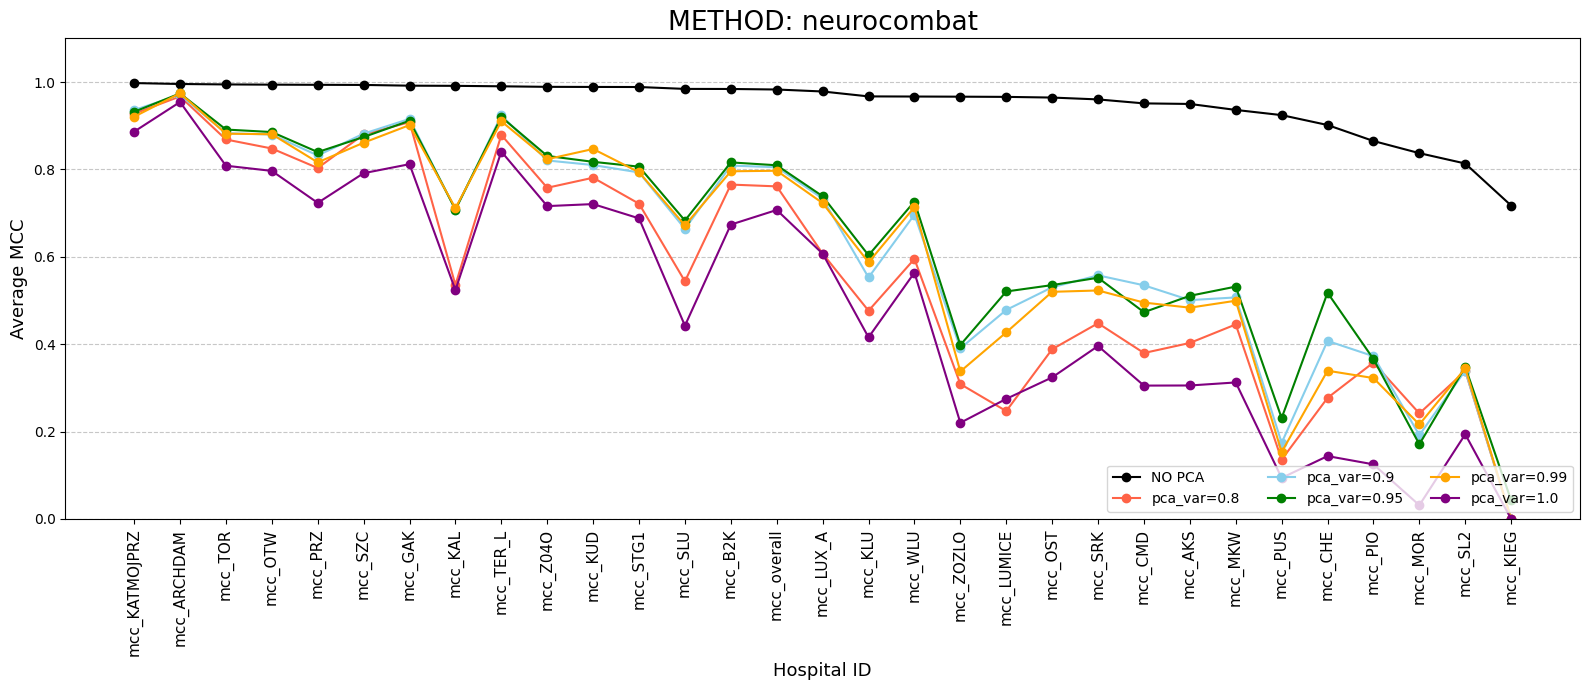

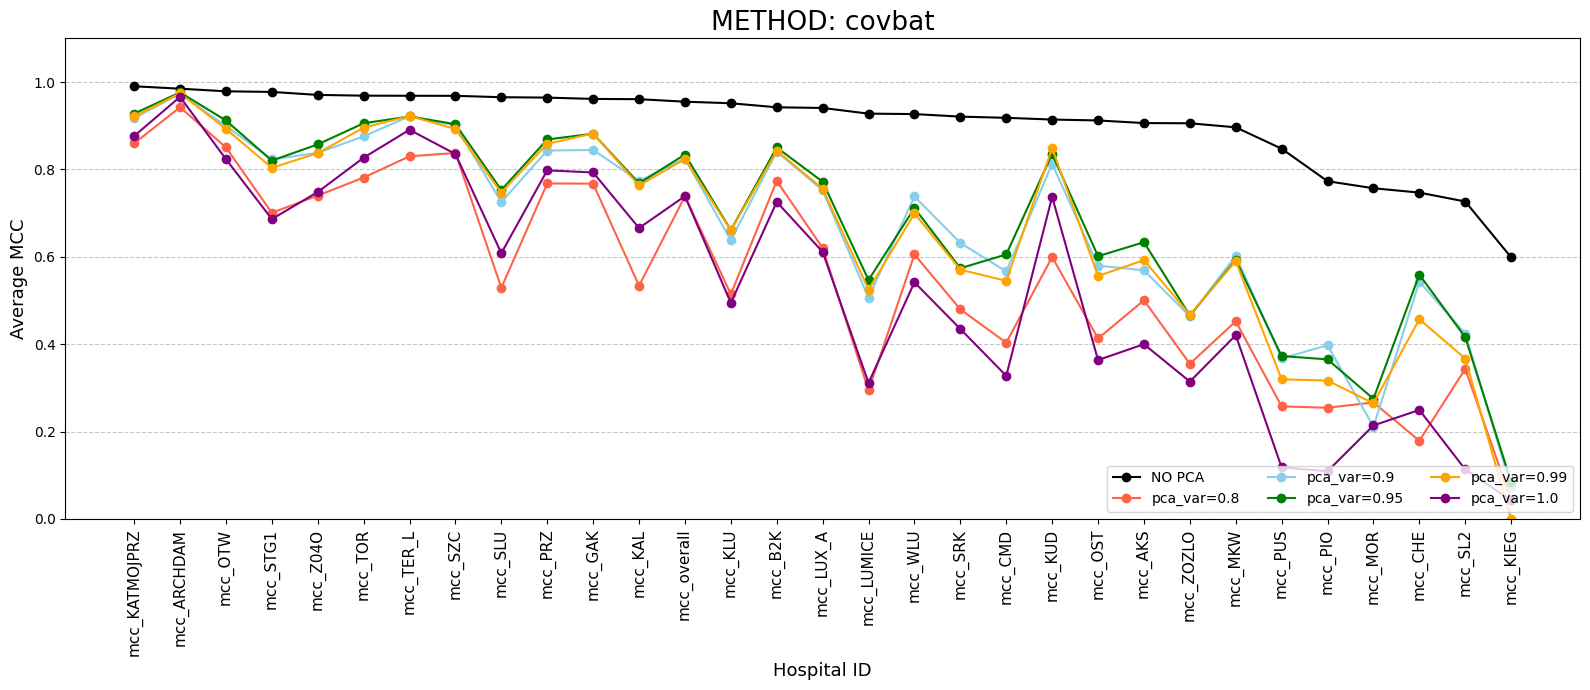

In [7]:
color_grid = [
    'black', 'tomato', 'skyblue', 'green',
    'orange', 'purple', 'brown', 'cyan',
    'magenta', 'yellow', 'pink', 'lime'
]

for method in METHODS:
    plt.figure(figsize=(16, 7))
    reference_series = site_mean_results_df.loc[method, 0.0]
    sort_idx = reference_series.values.argsort()[::-1]
    class_labels_sorted = reference_series.index.values[sort_idx]

    for pca_idx, pca_var in enumerate(site_mean_results_df.loc[method].index.unique()):
        results_series = site_mean_results_df.loc[method, pca_var]
        mcc_values = [results_series.get(h, np.nan) for h in class_labels_sorted]

        plt.plot(
            class_labels_sorted,
            mcc_values,
            marker='o',
            linestyle='-',
            color=color_grid[pca_idx],
            label=f"pca_var=" + str(pca_var) if pca_var != 0.0 else "NO PCA"
        )

    plt.ylabel("Average MCC", fontsize=13)
    plt.xlabel("Hospital ID", fontsize=13)
    plt.xticks(rotation=90, fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1.1)
    plt.legend(loc='lower right', fontsize=10, ncol=3)
    plt.title("METHOD: " + method, fontsize=19)
    plt.tight_layout()
    plt.show()